In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm, TwoSlopeNorm
from pathlib import Path
from tqdm import tqdm
from glob import glob
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt
import seaborn as sns
import yaml

#plt.rcParams['figure.dpi'] = 300

#### Import embeddings

In [3]:
# working folder
#
tiles_dir = "/home/users/flojo/Data/Tiles"
tiles_folder = '2020_test_24000tr_64px'
tiles_filepath = Path(tiles_dir) / tiles_folder
tiles_meta_filepath = tiles_filepath / "meta"
tiles_images_filepath = tiles_filepath / "images"
embeddings_file = tiles_meta_filepath / "embs.nc"

In [6]:
tiles_ds = xr.open_dataset(embeddings_file)
tiles_ds

<xarray.Dataset> Size: 32MB
Dimensions:        (tile_id: 24000, tile_type: 3, emb_dim: 100, isomap_dim: 2)
Coordinates:
  * tile_id        (tile_id) int32 96kB 0 1 2 3 4 ... 23996 23997 23998 23999
  * tile_type      (tile_type) object 24B 'anchor' 'neighbor' 'distant'
Dimensions without coordinates: emb_dim, isomap_dim
Data variables:
    embs           (tile_type, tile_id, emb_dim) float32 29MB ...
    c_lat          (tile_type, tile_id) float32 288kB ...
    c_lon          (tile_type, tile_id) float32 288kB ...
    time           (tile_type, tile_id) datetime64[ns] 576kB ...
    skt            (tile_type, tile_id) float32 288kB ...
    msl            (tile_type, tile_id) float32 288kB ...
    t800           (tile_type, tile_id) float32 288kB ...
    M800           (tile_type, tile_id) float32 288kB ...
    theta_800      (tile_type, tile_id) float32 288kB ...
    theta_skt      (tile_type, tile_id) float32 288kB ...
    isomap_coords  (isomap_dim, tile_type, tile_id) float32 576kB ...

In [4]:
with open(tiles_meta_filepath / "tile_locations.yaml", 'r') as f:
    tile_locations = yaml.safe_load(f)
tile_locations

{1: {'aqua': {'MYD021KM.A2020001.1350': [{'loc': {'latitude': 53.89498519897461,
      'longitude': -17.62111473083496,
      'scene_id': 'MYD021KM.A2020001.1350',
      'x_c': 384,
      'y_c': 896},
     'region': 1,
     'tile_type': 'anchor',
     'triplet_collection': 'study',
     'triplet_id': 12},
    {'loc': {'latitude': 54.04989242553711,
      'longitude': -16.65021514892578,
      'scene_id': 'MYD021KM.A2020001.1350',
      'x_c': 320,
      'y_c': 896},
     'region': 1,
     'tile_type': 'neighbor',
     'triplet_collection': 'study',
     'triplet_id': 12},
    {'loc': {'latitude': 58.26952362060547,
      'longitude': -18.508127212524414,
      'scene_id': 'MYD021KM.A2020001.1350',
      'x_c': 288,
      'y_c': 1376},
     'region': 1,
     'tile_type': 'anchor',
     'triplet_collection': 'study',
     'triplet_id': 80},
    {'loc': {'latitude': 58.818275451660156,
      'longitude': -18.858379364013672,
      'scene_id': 'MYD021KM.A2020001.1350',
      'x_c': 288,
  

#### Add lat, lon and time from tile metadata

In [5]:
def maketime(sceneid):
    ''' make datetime64 from modis tile sceneid e.g. MYD02HKM.A2022002.1555'''
    year = sceneid[10:14]
    dayofyear = sceneid[14:17]
    hour = sceneid[18:20]
    minute = sceneid[20:22]

    time = dt.datetime(int(year), 1, 1, int(hour), int(minute)) + dt.timedelta(int(dayofyear) - 1)
    time = np.datetime64(time, 'ns')
    return time

In [6]:
# Add lon and lat to nc file or just read from meta data and add to ds each time?

tiles_ds['c_lat'] = xr.zeros_like(tiles_ds['isomap_coords'][0])
tiles_ds['c_lon'] = xr.zeros_like(tiles_ds['isomap_coords'][0])
tiles_ds['time'] = xr.zeros_like(tiles_ds['isomap_coords'][0], dtype='datetime64[ns]')

In [7]:
# Extract lat and lon etc. for each tile from yaml files

for month in tile_locations.keys():
    for satellite in tile_locations[month].keys():
        for scene_id in tile_locations[month][satellite].keys():
            for tile in tile_locations[month][satellite][scene_id]:
                tile_id = tile['triplet_id']
                tile_type = tile['tile_type']
                latitude = tile['loc']['latitude']
                longitude = tile['loc']['longitude']

                tiles_ds["c_lat"].loc[dict(tile_id=tile_id, tile_type=tile_type)] = latitude
                tiles_ds["c_lon"].loc[dict(tile_id=tile_id, tile_type=tile_type)] = longitude
                tiles_ds["time"].loc[dict(tile_id=tile_id, tile_type=tile_type)] = maketime(scene_id)


tiles_ds

<xarray.Dataset> Size: 3MB
Dimensions:        (tile_id: 2400, tile_type: 3, emb_dim: 100, isomap_dim: 2)
Coordinates:
  * tile_id        (tile_id) int64 19kB 0 1 2 3 4 5 ... 2395 2396 2397 2398 2399
  * tile_type      (tile_type) <U8 96B 'anchor' 'neighbor' 'distant'
Dimensions without coordinates: emb_dim, isomap_dim
Data variables:
    embs           (tile_type, tile_id, emb_dim) float32 3MB ...
    isomap_coords  (isomap_dim, tile_type, tile_id) float32 58kB ...
    c_lat          (tile_type, tile_id) float32 29kB 54.11 56.9 ... 54.96 46.2
    c_lon          (tile_type, tile_id) float32 29kB -51.19 -52.24 ... -34.14
    time           (tile_type, tile_id) datetime64[ns] 58kB 2020-01-02T16:10:...

In [19]:
# count how many data points at each time of day
hours = tiles_ds['time'].dt.hour
hours_counts = hours.groupby(hours).count()
hours_counts

#### Load ERA data and add to dataset

In [8]:
variables = ['skt', 'msl', 't800', 'M800']
for v in variables:
    tiles_ds[v] = xr.full_like(tiles_ds['c_lat'], fill_value=np.nan)

In [9]:
# ERA5  surface level analysis parameter data on CEDA 
# - subdirectories like YYYY/MM/DD

# Variables for CAO index:
# skt: Skin temperature. Files like ecmwf-era5_oper_an_sfc_202001011200.skt.nc
# msl: Mean sea level pressure. Files like ecmwf-era5_oper_an_sfc_202001011200.msl.nc

era5_dir = "/badc/ecmwf-era5/data/oper/an_sfc/"

In [10]:
# add era5 data from CEDA archive for each tile location
# do all tiles from each granule at once to avoid opening the same era5 file multiple times 

variables = ['skt', 'msl']

for month in tile_locations.keys():
    for satellite in tile_locations[month].keys():
        for scene_id in tqdm(tile_locations[month][satellite].keys()):
            time = maketime(scene_id)
            time = pd.Timestamp(time).round('h') # round time to nearest hour to select era5 file
            for v in variables:
                filepath = Path(era5_dir) / f"{time:%Y/%m/%d}" / f"ecmwf-era5_oper_an_sfc_{time:%Y%m%d%H}00.{v}.nc"
                if filepath.exists():
                    ds = xr.open_dataset(filepath) # open relevant era5 data

                    for tile in tile_locations[month][satellite][scene_id]:
                        tile_id = tile['triplet_id']
                        tile_type = tile['tile_type']
                        lat = tile['loc']['latitude']
                        lon = tile['loc']['longitude']

                        tiles_ds[v].loc[dict(tile_id=tile_id, tile_type=tile_type)] = \
                            ds[v].sel(longitude=lon%360, latitude=lat, method='nearest').item() # era5 data on CEDA uses 0-360 longitude
                else:
                    print(f"File not found: {filepath}")

100%|██████████| 28/28 [00:18<00:00,  1.51it/s]


In [11]:
tiles_ds

<xarray.Dataset> Size: 3MB
Dimensions:        (tile_id: 2400, tile_type: 3, emb_dim: 100, isomap_dim: 2)
Coordinates:
  * tile_id        (tile_id) int64 19kB 0 1 2 3 4 5 ... 2395 2396 2397 2398 2399
  * tile_type      (tile_type) <U8 96B 'anchor' 'neighbor' 'distant'
Dimensions without coordinates: emb_dim, isomap_dim
Data variables:
    embs           (tile_type, tile_id, emb_dim) float32 3MB ...
    isomap_coords  (isomap_dim, tile_type, tile_id) float32 58kB ...
    c_lat          (tile_type, tile_id) float32 29kB 54.11 56.9 ... 54.96 46.2
    c_lon          (tile_type, tile_id) float32 29kB -51.19 -52.24 ... -34.14
    time           (tile_type, tile_id) datetime64[ns] 58kB 2020-01-02T16:10:...
    skt            (tile_type, tile_id) float32 29kB 276.2 275.8 ... 285.0 288.0
    msl            (tile_type, tile_id) float32 29kB 9.888e+04 ... 1.012e+05
    t800           (tile_type, tile_id) float32 29kB nan nan nan ... nan nan nan
    M800           (tile_type, tile_id) float32 29kB nan nan nan ... nan nan nan

In [12]:
# Also need temperature at 800hPa, pressure levels not on CEDA
filename = "/gws/nopw/j04/sensecdt/data/internal/ERA5/NAtlantic_Arctic/T_at_800hPa_2020.nc"
t800_ds = xr.open_dataset(filename)
t800_ds

<xarray.Dataset> Size: 3GB
Dimensions:         (valid_time: 8784, pressure_level: 1, latitude: 149,
                     longitude: 521)
Coordinates:
    number          int64 8B ...
  * valid_time      (valid_time) datetime64[ns] 70kB 2020-01-01 ... 2020-12-3...
  * pressure_level  (pressure_level) float64 8B 800.0
  * latitude        (latitude) float64 1kB 82.0 81.75 81.5 ... 45.5 45.25 45.0
  * longitude       (longitude) float64 4kB -65.0 -64.75 -64.5 ... 64.75 65.0
    expver          (valid_time) <U4 141kB ...
Data variables:
    t               (valid_time, pressure_level, latitude, longitude) float32 3GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-24T11:02 GRIB to CDM+CF via cfgrib-0.9.1...

In [13]:
t800_ds.load()

for tile_id in tqdm(tiles_ds.tile_id):
    for tile_type in ['anchor', 'neighbor', 'distant']:
        lat = tiles_ds["c_lat"].loc[dict(tile_id=tile_id, tile_type=tile_type)]
        lon = tiles_ds["c_lon"].loc[dict(tile_id=tile_id, tile_type=tile_type)]
        time = tiles_ds["time"].loc[dict(tile_id=tile_id, tile_type=tile_type)]
        
        tiles_ds['t800'].loc[dict(tile_id=tile_id, tile_type=tile_type)] = \
            t800_ds['t'].sel(latitude=lat, longitude=lon, valid_time=time, 
                        pressure_level=800, method='nearest')

100%|██████████| 2400/2400 [00:20<00:00, 115.78it/s]


In [14]:
# Calculate CAO index
# calculate surface theta
# calculate 800hPa theta

tiles_ds['theta_800'] = tiles_ds['t800'] * (1000 / 800) ** 0.286
tiles_ds['theta_skt'] = tiles_ds['skt'] * (1000 / (tiles_ds['msl']/100)) ** 0.286
tiles_ds['M800'] = tiles_ds['theta_skt'] - tiles_ds['theta_800']
tiles_ds

<xarray.Dataset> Size: 3MB
Dimensions:        (tile_id: 2400, tile_type: 3, emb_dim: 100, isomap_dim: 2)
Coordinates:
  * tile_id        (tile_id) int64 19kB 0 1 2 3 4 5 ... 2395 2396 2397 2398 2399
  * tile_type      (tile_type) <U8 96B 'anchor' 'neighbor' 'distant'
Dimensions without coordinates: emb_dim, isomap_dim
Data variables:
    embs           (tile_type, tile_id, emb_dim) float32 3MB ...
    isomap_coords  (isomap_dim, tile_type, tile_id) float32 58kB ...
    c_lat          (tile_type, tile_id) float32 29kB 54.11 56.9 ... 54.96 46.2
    c_lon          (tile_type, tile_id) float32 29kB -51.19 -52.24 ... -34.14
    time           (tile_type, tile_id) datetime64[ns] 58kB 2020-01-02T16:10:...
    skt            (tile_type, tile_id) float32 29kB 276.2 275.8 ... 285.0 288.0
    msl            (tile_type, tile_id) float32 29kB 9.888e+04 ... 1.012e+05
    t800           (tile_type, tile_id) float32 29kB 266.8 252.4 ... 283.3 267.0
    M800           (tile_type, tile_id) float32 29kB -7.272 6.282 ... 2.38
    theta_800      (tile_type, tile_id) float32 29kB 284.4 269.1 ... 302.0 284.6
    theta_skt      (tile_type, tile_id) float32 29kB 277.1 275.3 ... 284.7 287.0

In [15]:
# save to netcdf
tiles_ds.to_netcdf(embeddings_file)

### Plot heatmaps on manifold dimensions

In [4]:
tiles_ds = xr.open_dataset(embeddings_file)

In [5]:
tiles_ds['isomap_coords'][0].values

array([[-0.9956351 , -0.92827994, -0.5584089 , ..., -0.54888123,
         0.53212935,  0.24716733],
       [-0.91109014, -0.9073632 , -0.05508526, ..., -0.28543556,
         0.54996294,  0.19304769],
       [ 0.55352986,  0.4482189 ,  1.1272373 , ...,  0.72539467,
        -0.6777416 ,  0.24321045]], dtype=float32)

In [7]:
# convert isomap coords and variables of interest to a pd dataframe for binning and plotting

variables = ['M800']
tiles_df = tiles_ds[variables].to_dataframe()
tiles_df['isomap_x'] = tiles_ds['isomap_coords'][0].to_dataframe()
tiles_df['isomap_y'] = tiles_ds['isomap_coords'][1].to_dataframe()
tiles_df.head()

M800  isomap_x  isomap_y
tile_type tile_id                              
anchor    0       -4.548401 -0.995635  0.234641
          1       -5.458069 -0.928280  0.159142
          2        1.680573 -0.558409 -0.079218
          3       -1.294678  0.572288 -0.444902
          4       -4.787903 -0.396339 -0.091013

In [8]:
print("xmax: ", tiles_df['isomap_x'].max())
print("xmin: ", tiles_df['isomap_x'].min())
print("ymax: ", tiles_df['isomap_y'].max())
print("ymin: ", tiles_df['isomap_y'].min())

xmax:  1.6033552
xmin:  -1.1982881
ymax:  1.0338122
ymin:  -0.8465729


In [38]:
def define_bins(xmax, xmin, ymax, ymin, res):
    ''' Define bins for isomap x and y, based on max and min values of isomap coordinates 
    and resolution in isomap space'''
    x_bin_no = int((xmax - xmin) / res)
    y_bin_no = int((ymax - ymin) / res)
    x_bins = np.linspace(xmin, xmax, x_bin_no + 1)
    y_bins = np.linspace(ymin, ymax, y_bin_no + 1)
    dp = len(str(res/2).split('.')[1]) # no. of decimal places for bin labels
    x_bin_labels = [f'{i:.{dp}f}' for i in np.linspace(xmin + res/2, xmax - res/2, x_bin_no)]
    y_bin_labels = [f'{i:.{dp}f}' for i in np.linspace(ymin + res/2, ymax - res/2, y_bin_no)]
    return x_bins, y_bins, x_bin_labels, y_bin_labels

In [35]:
xmax = 1.5
xmin = -1.5
ymax = 1
ymin = -1
res = 0.1

x_bins, y_bins, x_bin_labels, y_bin_labels = define_bins(xmax, xmin, ymax, ymin, res)

In [10]:
# bin the data based on isomap coordinates

tiles_df['isomap_x_bin'] = pd.cut(tiles_df['isomap_x'], bins=x_bins, labels=x_bin_labels)
tiles_df['isomap_y_bin'] = pd.cut(tiles_df['isomap_y'], bins=y_bins, labels=y_bin_labels)
tiles_df.head()

M800  isomap_x  isomap_y isomap_x_bin isomap_y_bin
tile_type tile_id                                                        
anchor    0       -4.548401 -0.995635  0.234641        -0.98         0.22
          1       -5.458069 -0.928280  0.159142        -0.93         0.17
          2        1.680573 -0.558409 -0.079218        -0.58        -0.08
          3       -1.294678  0.572288 -0.444902         0.58        -0.43
          4       -4.787903 -0.396339 -0.091013        -0.38        -0.08

In [15]:
# find the mean of a given variable in each bin

def bin_means(df, variable):
    means = df.groupby(['isomap_x_bin', 'isomap_y_bin'])[variable].mean().unstack(level=0)
    means = means.iloc[::-1]    # flip the dataframe so that the y axis is increasing upwards
    return means

In [18]:
# find the variance in each bin

def bin_variances(df, variable):
    variances = df.groupby(['isomap_x_bin', 'isomap_y_bin'])[variable].var().unstack(level=0)
    variances = variances.iloc[::-1]    # flip the dataframe so that the y axis is increasing upwards
    return variances

In [24]:
# find the standard deviation in each bin

def bin_std(df, variable):
    stds = df.groupby(['isomap_x_bin', 'isomap_y_bin'])[variable].std().unstack(level=0)
    stds = stds.iloc[::-1]    # flip the dataframe so that the y axis is increasing upwards
    return stds

In [19]:
# plot heatmap of bin values

def plot_bins(bins_df, cmap, title, center=None, vmin=None):
    fig = sns.heatmap(bins_df, cmap=cmap, center=center, vmin=vmin)
    fig.title.set_text(title)
    fig.set_xlabel('Isomap x', fontsize=10)
    fig.set_ylabel('Isomap y', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    return fig

In [13]:
tiles_df['M800'].max(), tiles_df['M800'].min()

(np.float32(15.924561), np.float32(-33.004944))

/tmp/ipykernel_3098457/3692898104.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby(['isomap_x_bin', 'isomap_y_bin'])[variable].mean().unstack(level=0)


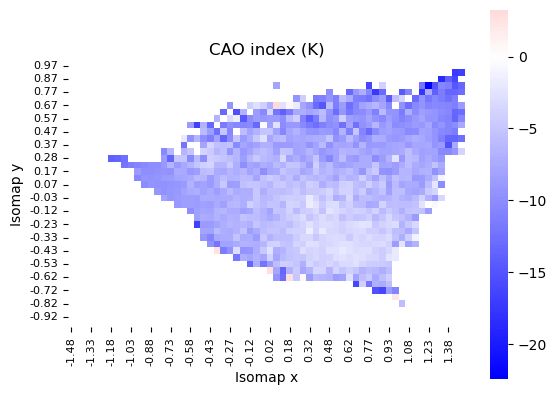

In [20]:
cao_means = bin_means(tiles_df, 'M800')
plot_bins(cao_means, 'bwr', 'CAO index (K)', center=0)
plt.gca().set_aspect('equal', adjustable='box')


/tmp/ipykernel_3098457/1905490221.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stds = df.groupby(['isomap_x_bin', 'isomap_y_bin'])[variable].std().unstack(level=0)


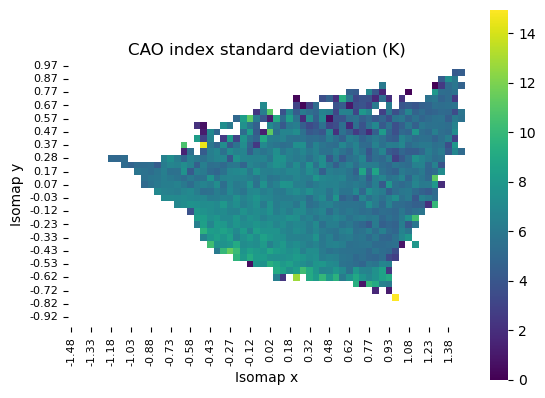

In [25]:
cao_std = bin_std(tiles_df, 'M800')
plot_bins(cao_std, 'viridis', 'CAO index standard deviation (K)', vmin=0)
plt.gca().set_aspect('equal', adjustable='box')

/tmp/ipykernel_3098457/560681147.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  variances = df.groupby(['isomap_x_bin', 'isomap_y_bin'])[variable].var().unstack(level=0)


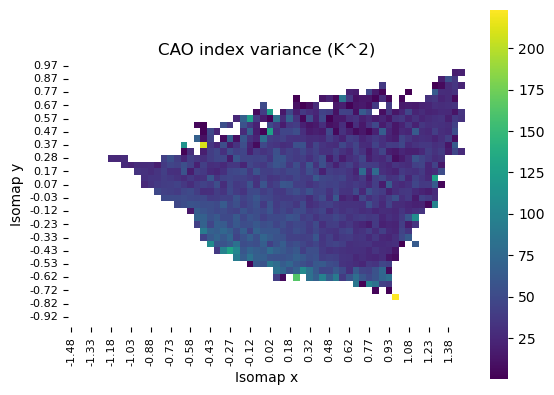

In [23]:
cao_variance = bin_variances(tiles_df, 'M800')
plot_bins(cao_variance, 'viridis', 'CAO index variance (K^2)')
plt.gca().set_aspect('equal', adjustable='box')

/tmp/ipykernel_8552/3653472894.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby(['isomap_x_bin', 'isomap_y_bin'])[var].mean().unstack(level=0)


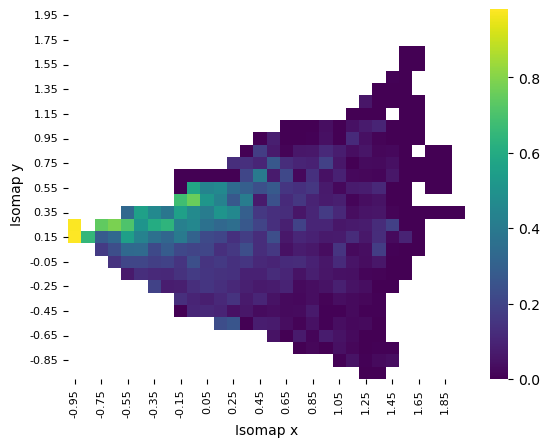

In [23]:
lf_means = bin_means(tiles_df, 'land_fraction')
plot_means(lf_means, 'viridis', 'Mean land fraction');

/tmp/ipykernel_8552/3653472894.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby(['isomap_x_bin', 'isomap_y_bin'])[var].mean().unstack(level=0)


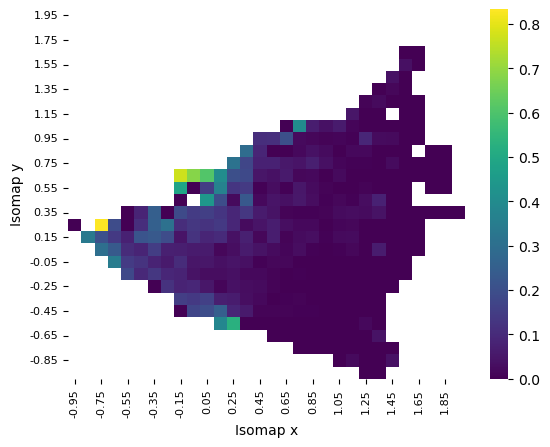

In [25]:
si_means = bin_means(tiles_df, 'siconc')
plot_means(si_means, 'viridis', 'Mean sea ice fraction');

/home/eefjg/miniconda3/envs/main/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/eefjg/miniconda3/envs/main/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


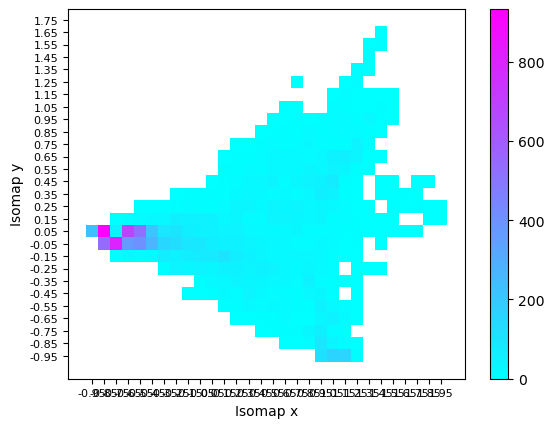

In [30]:

fig = sns.histplot(tiles_df, x='isomap_x_bin', y='isomap_y_bin', cmap='cool', cbar=True)
#fig.title.set_text(title)
fig.set_xlabel('Isomap x', fontsize=10)
fig.set_ylabel('Isomap y', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.gca().invert_yaxis()

/home/eefjg/miniconda3/envs/main/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/eefjg/miniconda3/envs/main/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


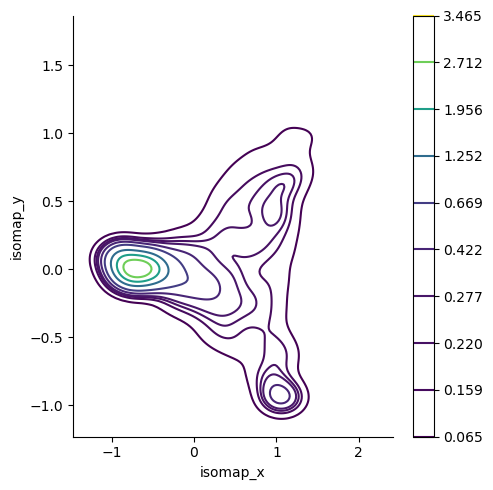

In [15]:
sns.displot(tiles_df, x='isomap_x', y='isomap_y', cmap='viridis', cbar=True, kind='kde', levels=10)